In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, auc, classification_report
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import shap
import joblib

df = pd.read_csv("Train.csv")

c:\Users\HD\miniforge3\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
target = "Reached.on.Time_Y.N"
X = df.drop(columns=[target])
y = df[target]

numeric_cols = X.select_dtypes(include=["int64", "float64"]).columns.tolist()
categorical_cols = X.select_dtypes(include=["object"]).columns.tolist()

print("Numeric:", numeric_cols)
print("Categorical:", categorical_cols)


Numeric: ['ID', 'Customer_care_calls', 'Customer_rating', 'Cost_of_the_Product', 'Prior_purchases', 'Discount_offered', 'Weight_in_gms']
Categorical: ['Warehouse_block', 'Mode_of_Shipment', 'Product_importance', 'Gender']


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [4]:
numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown="ignore")

preprocess = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_cols),
        ("cat", categorical_transformer, categorical_cols)
    ]
)

In [5]:
final_model = Pipeline([
    ("preprocess", preprocess),
    ("rf", RandomForestClassifier(
        n_estimators=250,
        max_depth=18,
        random_state=42
    ))
])

print("Training model...")
final_model.fit(X_train, y_train)

Training model...


,steps,"[('preprocess', ...), ('rf', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [6]:
pred = final_model.predict(X_test)
acc = accuracy_score(y_test, pred)

print("\n=== ACCURACY ===")
print(acc)
print("\n=== REPORT ===")
print(classification_report(y_test, pred))


=== ACCURACY ===
0.6618181818181819

=== REPORT ===
              precision    recall  f1-score   support

           0       0.56      0.78      0.65       887
           1       0.80      0.58      0.67      1313

    accuracy                           0.66      2200
   macro avg       0.68      0.68      0.66      2200
weighted avg       0.70      0.66      0.66      2200



In [7]:
joblib.dump(final_model, "delivery_model.pkl")
feature_names = list(final_model.named_steps["preprocess"].get_feature_names_out())
joblib.dump(feature_names, "model_features.pkl")
print("\nSaved: model + features")



Saved: model + features


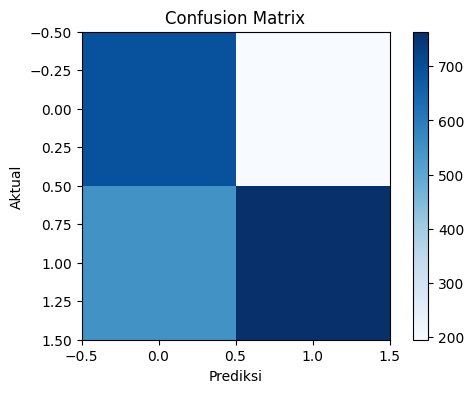

In [8]:
cm = confusion_matrix(y_test, pred)
plt.figure(figsize=(6,4))
plt.imshow(cm, cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Prediksi")
plt.ylabel("Aktual")
plt.colorbar()
plt.savefig("confusion_matrix.png", dpi=300)
plt.show()

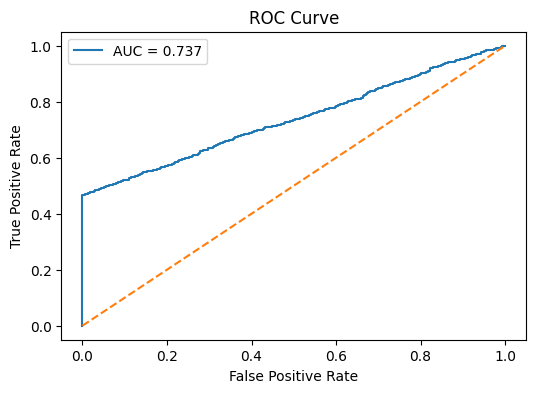

In [9]:
pred_prob = final_model.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, pred_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, label="AUC = %.3f" % roc_auc)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.savefig("roc_curve.png", dpi=300)
plt.show()

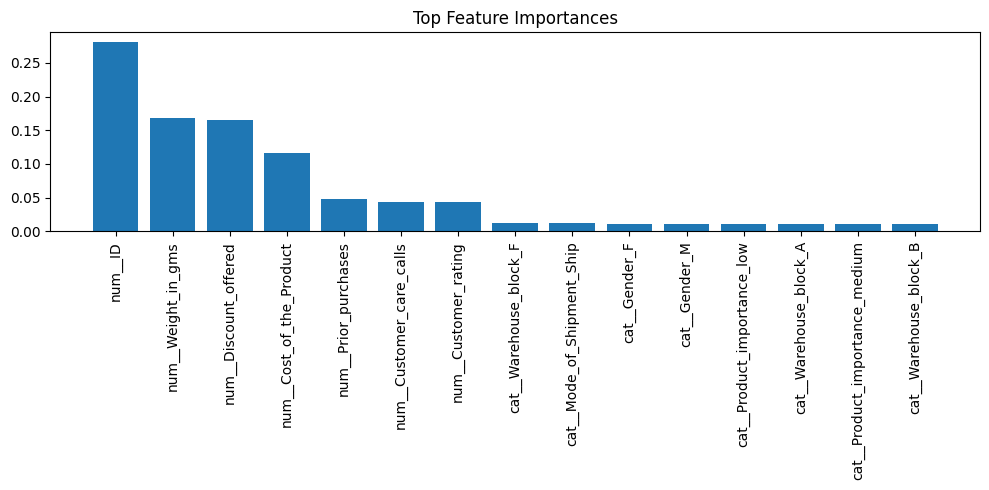

In [13]:
rf = final_model.named_steps["rf"]
importances = rf.feature_importances_

plt.figure(figsize=(10,5))
imp_sorted_idx = np.argsort(importances)[::-1]
plt.bar([feature_names[i] for i in imp_sorted_idx[:15]],
        importances[imp_sorted_idx[:15]])
plt.xticks(rotation=90)
plt.title("Top Feature Importances")
plt.tight_layout()
plt.savefig("feature_importances.png", dpi=300)
plt.show()



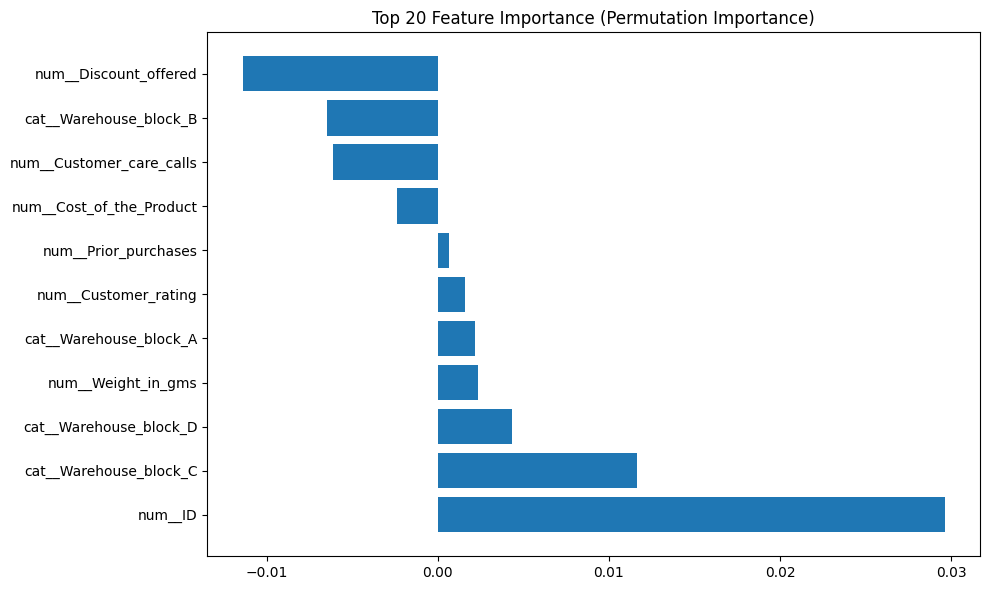

In [15]:
from sklearn.inspection import permutation_importance

r = permutation_importance(
    final_model, X_test, y_test,
    n_repeats=10,
    random_state=42
)

importances = r.importances_mean
sorted_idx = np.argsort(importances)[::-1]

plt.figure(figsize=(10,6))
plt.barh(np.array(feature_names)[sorted_idx][:20], importances[sorted_idx][:20])
plt.title("Top 20 Feature Importance (Permutation Importance)")
plt.tight_layout()
plt.savefig("permutation_importance.png")
plt.show()
